# Import Libraries

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import multiprocessing

import pickle
import catboost as cb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error)
from sklearn.model_selection import (cross_val_score, GridSearchCV,
                                     RandomizedSearchCV, RepeatedStratifiedKFold,
                                     train_test_split)

# Set Random State

In [2]:
global rand_state
rand_state = 2023

# Utility Functions

In [3]:
def get_mean_cvs(model, X, y):
    global rand_state
    cv = RepeatedStratifiedKFold(n_splits=10,
                                 n_repeats=3,
                                 random_state=rand_state)
    
    scores = cross_val_score(model, X, y,
                             scoring='accuracy',
                             cv=cv,
                             n_jobs=-1,
                             error_score='raise')
    
    print(f'Cross Validation Accuracy Score: {scores.mean():.3f} ({scores.std():.3f})')
    
    return scores


def evaluate_model(y_true, y_pred):
    """Prints a classification report and plots a confusion matrix."""
    labels = ['High Shares', 'Average Shares', 'Low Shares']

    print(classification_report(y_true=y_true,
                                y_pred=y_pred,
                                target_names=labels, 
                                digits=3))

    cm = confusion_matrix(y_true=y_true,
                          y_pred=y_pred,
                          labels=labels)

    plt.imshow(cm, cmap=plt.cm.Blues)
    threshold = cm.min() + ((cm.max() - cm.min()) / 2)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]): 
            plt.text(x=j, y=i, s=cm[i,j], 
                      color='w' if cm[i,j] > threshold else 'black',
                      fontsize=16, ha='center', va='center')

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()

def get_best_params(model, grid, X, y, is_iterate_all):
    # Estimates model performance
    cv = RepeatedStratifiedKFold(n_splits=10,
                                 n_repeats=3, 
                                 random_state=rand_state)

    if is_iterate_all:
        # Tries all combinations of hyperparameters specified in grid to
        # get best parameters
        scv = GridSearchCV(estimator=model,
                           param_grid=grid,
                           n_jobs=-1,
                           cv=cv,
                           scoring='accuracy',
                           error_score=0)
    else:
        scv = RandomizedSearchCV(estimator=model,
                                 param_distributions=grid,
                                 n_iter=10,
                                 n_jobs=-1,
                                 cv=None, 
                                 scoring='accuracy', 
                                 random_state=rand_state)
    
    grid_result = scv.fit(X, y)
    
    # Results summary
    print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print(f'{mean} ({stdev}) with: {param}')
    print("Best Parameters: " +  str(grid_result.best_params_))
        
    return grid_result

# Load Dataset

In [4]:
X_train = pd.read_csv('./dataset/SmartLocal/X_train.csv')
y_train = pd.read_csv('./dataset/SmartLocal/y_train.csv')

X_test = pd.read_csv('./dataset/SmartLocal/X_test.csv')
y_test = pd.read_csv('./dataset/SmartLocal/y_test.csv')

# Scaling Data

In [5]:
# Gradient descent and distance-based algorithms require feature scaling while tree-based algorithms do not.
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Probabilistic

## Logistic Regression

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 2023, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Cross Validation Accuracy Score: 0.480 (0.028)
                precision    recall  f1-score   support

   High Shares      0.371     0.269     0.311       283
Average Shares      0.486     0.563     0.522       245
    Low Shares      0.484     0.554     0.516       271

      accuracy                          0.456       799
     macro avg      0.447     0.462     0.450       799
  weighted avg      0.444     0.456     0.445       799



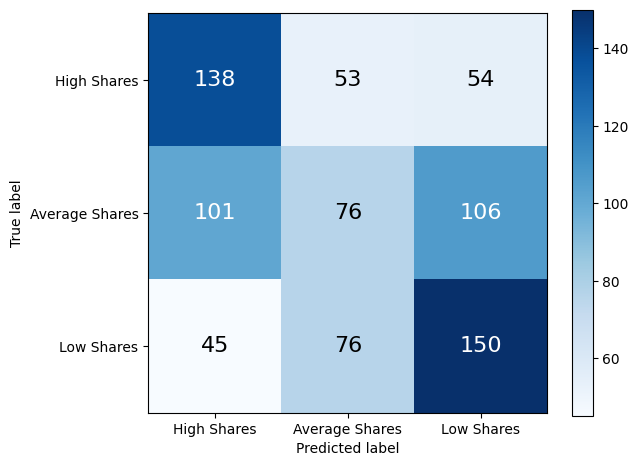

In [40]:
lr_base_model = LogisticRegression(max_iter=1000, random_state=rand_state)
print(lr_base_model.get_params())

get_mean_cvs(lr_base_model, X_train_scaled, y_train.to_numpy().ravel())

lr_base_model.fit(X_train_scaled, y_train.to_numpy().ravel())
y_pred_cb_base = lr_base_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_cb_base)

{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 2023, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Cross Validation Accuracy Score: 0.485 (0.028)
                precision    recall  f1-score   support

   High Shares      0.372     0.261     0.307       283
Average Shares      0.484     0.571     0.524       245
    Low Shares      0.489     0.561     0.522       271

      accuracy                          0.458       799
     macro avg      0.448     0.465     0.451       799
  weighted avg      0.446     0.458     0.447       799



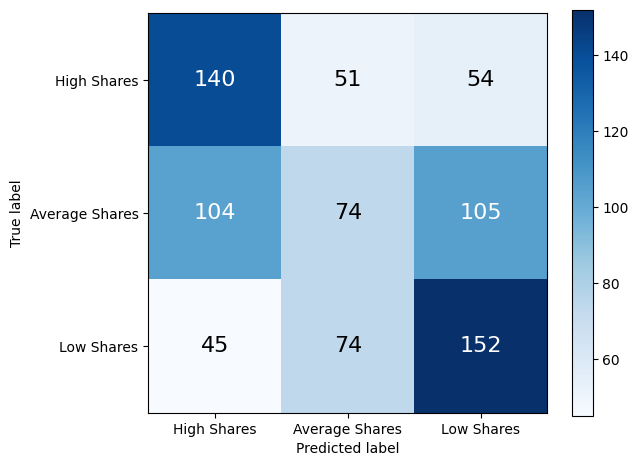

In [41]:
lr_GS = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=rand_state), 
    {
        'C': [0.1, 1, 10], 
        'solver': ['newton-cg', 'lbfgs', 'liblinear'], 
    }, 
    n_jobs=multiprocessing.cpu_count())

lr_GS = lr_GS.fit(X_train_scaled, y_train.to_numpy().ravel())

lr_best_model = lr_GS.best_estimator_
print(lr_best_model.get_params())

get_mean_cvs(lr_best_model, X_train_scaled, y_train.to_numpy().ravel())

lr_best_model.fit(X_train_scaled, y_train.to_numpy().ravel())
y_pred_lr_best = lr_best_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_lr_best)

In [52]:
pickle.dump(lr_best_model, open('./dataset/Model/lr_best_model.pkl', 'wb'))

## Naive Bayes

{'priors': None, 'var_smoothing': 1e-09}
Cross Validation Accuracy Score: 0.378 (0.013)
                precision    recall  f1-score   support

   High Shares      0.000     0.000     0.000       283
Average Shares      0.328     0.976     0.491       245
    Low Shares      0.638     0.162     0.259       271

      accuracy                          0.354       799
     macro avg      0.322     0.379     0.250       799
  weighted avg      0.317     0.354     0.238       799



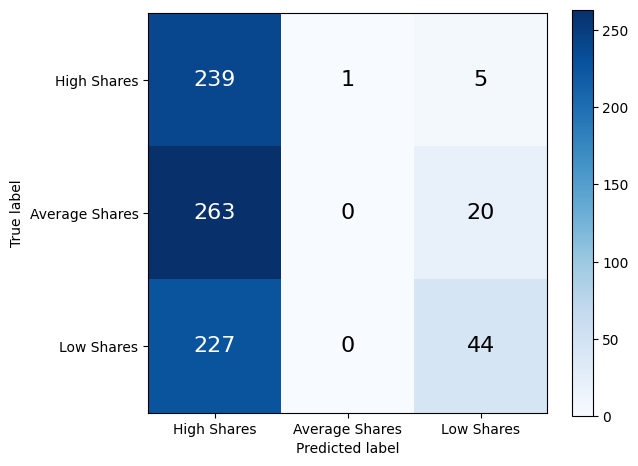

In [48]:
nb_base_model = GaussianNB()
print(nb_base_model.get_params())

get_mean_cvs(nb_base_model, X_train_scaled, y_train.to_numpy().ravel())

nb_base_model.fit(X_train_scaled, y_train.to_numpy().ravel())
y_pred_nb_base = nb_base_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_nb_base)

{'priors': None, 'var_smoothing': 0.001}
Cross Validation Accuracy Score: 0.470 (0.025)
                precision    recall  f1-score   support

   High Shares      0.372     0.261     0.307       283
Average Shares      0.484     0.571     0.524       245
    Low Shares      0.489     0.561     0.522       271

      accuracy                          0.458       799
     macro avg      0.448     0.465     0.451       799
  weighted avg      0.446     0.458     0.447       799



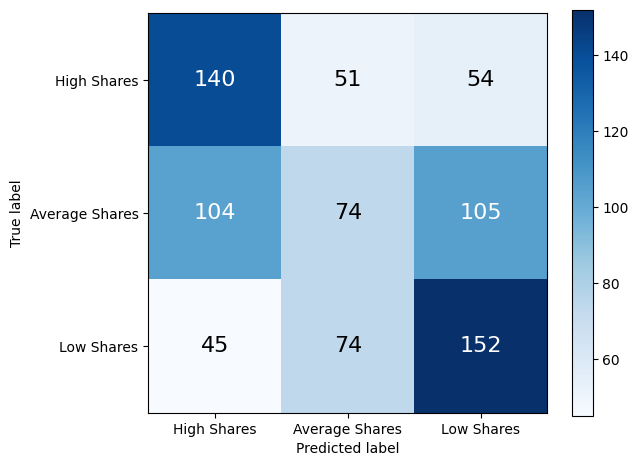

In [51]:
nb_GS = GridSearchCV(
    GaussianNB(), 
    {
        'var_smoothing': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2], 
    }, 
    n_jobs=multiprocessing.cpu_count())

nb_GS = nb_GS.fit(X_train_scaled, y_train.to_numpy().ravel())

nb_best_model = nb_GS.best_estimator_
print(nb_best_model.get_params())

get_mean_cvs(nb_best_model, X_train_scaled, y_train.to_numpy().ravel())

nb_best_model.fit(X_train_scaled, y_train.to_numpy().ravel())
y_pred_nb_best = nb_best_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_lr_best)

In [53]:
pickle.dump(nb_best_model, open('./dataset/Model/nb_best_model.pkl', 'wb'))

# Instance Based

## K-Nearest Neighbours

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Cross Validation Accuracy Score: 0.427 (0.027)
                precision    recall  f1-score   support

   High Shares      0.399     0.481     0.436       283
Average Shares      0.481     0.506     0.493       245
    Low Shares      0.515     0.380     0.437       271

      accuracy                          0.454       799
     macro avg      0.465     0.456     0.455       799
  weighted avg      0.463     0.454     0.454       799



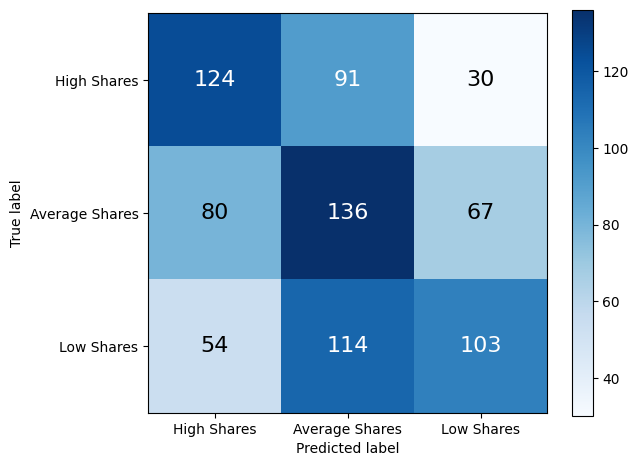

In [7]:
knn_base_model = KNeighborsClassifier()
print(knn_base_model.get_params())

get_mean_cvs(knn_base_model, X_train_scaled, y_train.to_numpy().ravel())

knn_base_model.fit(X_train_scaled, y_train.to_numpy().ravel())
y_pred_cb_base = knn_base_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_cb_base)

{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 11, 'p': 3, 'weights': 'distance'}
Cross Validation Accuracy Score: 0.452 (0.034)
                precision    recall  f1-score   support

   High Shares      0.394     0.350     0.371       283
Average Shares      0.453     0.527     0.487       245
    Low Shares      0.475     0.461     0.468       271

      accuracy                          0.442       799
     macro avg      0.441     0.446     0.442       799
  weighted avg      0.440     0.442     0.439       799



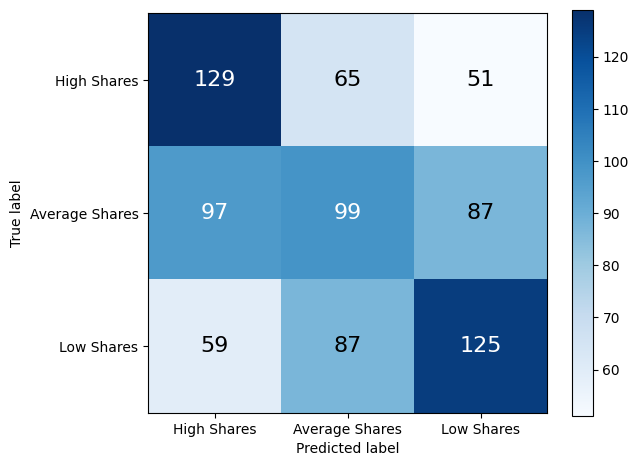

In [9]:
knn_GS = GridSearchCV(
    KNeighborsClassifier(), 
    {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [10, 20, 30],
        'p': [1, 2, 3]
    }, 
    n_jobs=multiprocessing.cpu_count())

knn_GS = knn_GS.fit(X_train_scaled, y_train.to_numpy().ravel())

knn_best_model = knn_GS.best_estimator_
print(knn_best_model.get_params())

get_mean_cvs(knn_best_model, X_train_scaled, y_train.to_numpy().ravel())

knn_best_model.fit(X_train_scaled, y_train.to_numpy().ravel())
y_pred_knn_best = knn_best_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_knn_best)

In [10]:
pickle.dump(knn_best_model, open('./dataset/Model/knn_best_model.pkl', 'wb'))

## Support Vector Machine

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Cross Validation Accuracy Score: 0.471 (0.028)
                precision    recall  f1-score   support

   High Shares      0.415     0.300     0.348       283
Average Shares      0.469     0.547     0.505       245
    Low Shares      0.510     0.579     0.542       271

      accuracy                          0.471       799
     macro avg      0.464     0.476     0.465       799
  weighted avg      0.463     0.471     0.462       799



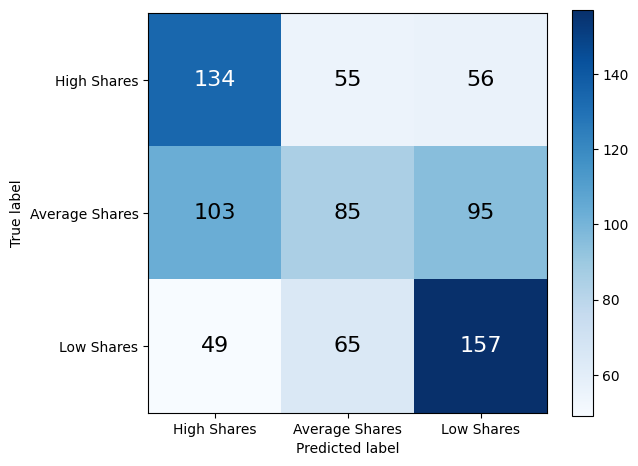

In [13]:
svm_base_model = SVC()
print(svm_base_model.get_params())

get_mean_cvs(svm_base_model, X_train_scaled, y_train.to_numpy().ravel())

svm_base_model.fit(X_train_scaled, y_train.to_numpy().ravel())
y_pred_cb_base = svm_base_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_cb_base)

{'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Cross Validation Accuracy Score: 0.480 (0.030)
                precision    recall  f1-score   support

   High Shares      0.348     0.194     0.249       283
Average Shares      0.481     0.559     0.517       245
    Low Shares      0.469     0.616     0.533       271

      accuracy                          0.449       799
     macro avg      0.433     0.457     0.433       799
  weighted avg      0.430     0.449     0.428       799



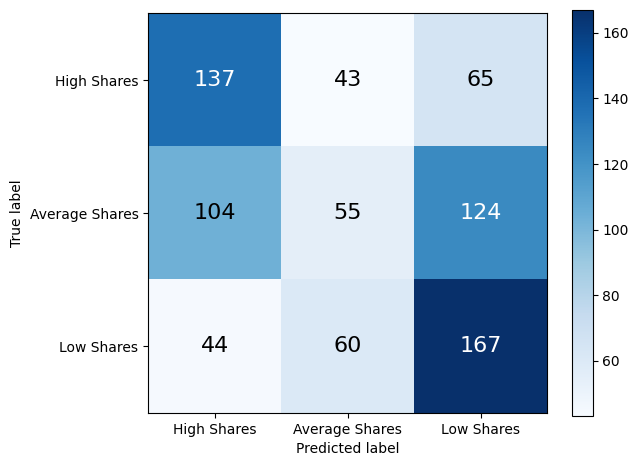

In [15]:
svm_GS = GridSearchCV(
    SVC(), 
    {
        'C': [0.1, 1, 10], 
        'kernel': ['linear', 'rbf'], 
        'gamma': ['scale', 'auto', 0.1, 1]
    }, 
    n_jobs=multiprocessing.cpu_count())

svm_GS = svm_GS.fit(X_train_scaled, y_train.to_numpy().ravel())

svm_best_model = svm_GS.best_estimator_
print(svm_best_model.get_params())

get_mean_cvs(svm_best_model, X_train_scaled, y_train.to_numpy().ravel())

svm_best_model.fit(X_train_scaled, y_train.to_numpy().ravel())
y_pred_svm_best = svm_best_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_svm_best)

In [16]:
pickle.dump(svm_best_model, open('./dataset/Model/svm_best_model.pkl', 'wb'))

# Tree Based

## Random Forest

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 2023, 'verbose': 0, 'warm_start': False}
Cross Validation Accuracy Score: 0.468 (0.029)
                precision    recall  f1-score   support

   High Shares      0.415     0.382     0.398       283
Average Shares      0.477     0.518     0.497       245
    Low Shares      0.498     0.502     0.500       271

      accuracy                          0.464       799
     macro avg      0.464     0.467     0.465       799
  weighted avg      0.462     0.464     0.463       799



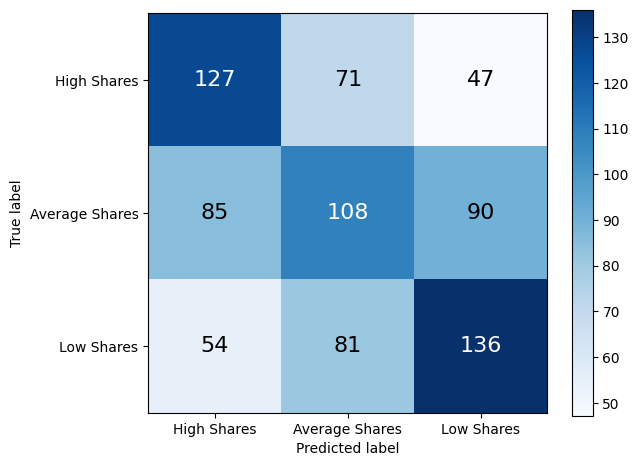

In [56]:
rf_base_model = RandomForestClassifier(
    random_state=rand_state, 
)
print(rf_base_model.get_params())

get_mean_cvs(rf_base_model, X_train, y_train.to_numpy().ravel())

rf_base_model.fit(X_train, y_train.to_numpy().ravel())
y_pred_cb_base = rf_base_model.predict(X_test)
evaluate_model(y_test, y_pred_cb_base)

LGBMClassifier(max_depth=20, objective='accuracy', random_state=2023)
Cross Validation Accuracy Score: 0.465 (0.029)


/Users/PoYan1/miniconda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/PoYan1/miniconda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


                precision    recall  f1-score   support

   High Shares      0.372     0.307     0.337       283
Average Shares      0.471     0.563     0.513       245
    Low Shares      0.507     0.509     0.508       271

      accuracy                          0.454       799
     macro avg      0.450     0.460     0.453       799
  weighted avg      0.448     0.454     0.449       799



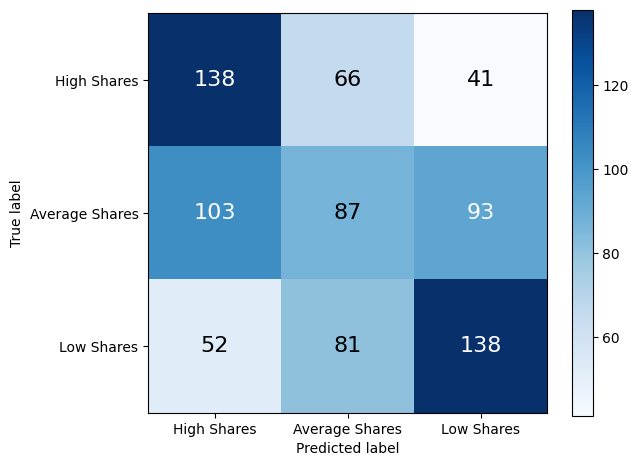

In [59]:
rf_GS = GridSearchCV(
    lgb.LGBMClassifier(objective='accuracy', random_state=rand_state), 
    {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 5, 10, 20],
    }, 
    n_jobs=multiprocessing.cpu_count())

rf_GS = rf_GS.fit(X_train, y_train.to_numpy().ravel())

rf_best_model = rf_GS.best_estimator_
print(rf_best_model)

get_mean_cvs(rf_best_model, X_train, y_train.to_numpy().ravel())

rf_best_model.fit(X_train, y_train)
y_pred_rf_best = rf_best_model.predict(X_test)
evaluate_model(y_test, y_pred_rf_best)

In [60]:
pickle.dump(rf_best_model, open('./dataset/Model/rf_best_model.pkl', 'wb'))

## CatBoost

{'verbose': False, 'random_state': 2023, 'objective': 'MultiClass'}
Cross Validation Accuracy Score: 0.474 (0.030)
                precision    recall  f1-score   support

   High Shares      0.405     0.353     0.377       283
Average Shares      0.502     0.571     0.534       245
    Low Shares      0.509     0.513     0.511       271

      accuracy                          0.474       799
     macro avg      0.472     0.479     0.474       799
  weighted avg      0.470     0.474     0.471       799



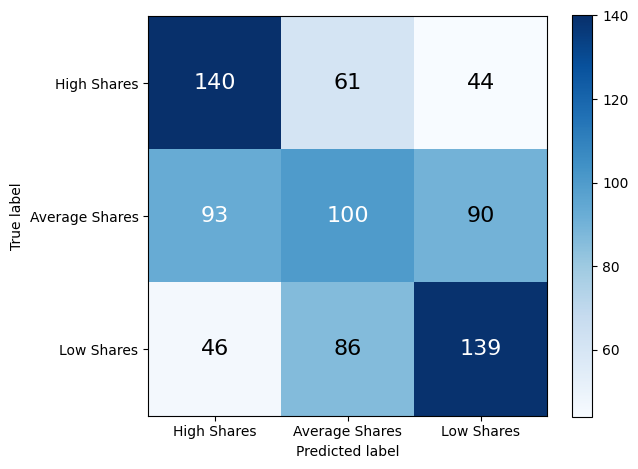

In [17]:
cb_base_model = cb.CatBoostClassifier(
    objective='MultiClass', 
    random_state=rand_state, 
    verbose=False
)
print(cb_base_model.get_params())

get_mean_cvs(cb_base_model, X_train, y_train)

cb_base_model.fit(X_train, y_train, verbose=False)
y_pred_cb_base = cb_base_model.predict(X_test)
evaluate_model(y_test, y_pred_cb_base)

{'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 3, 'verbose': False, 'n_estimators': 140, 'random_state': 2023, 'objective': 'MultiClass'}
Cross Validation Accuracy Score: 0.483 (0.026)
                precision    recall  f1-score   support

   High Shares       0.37      0.25      0.30       283
Average Shares       0.49      0.56      0.52       245
    Low Shares       0.47      0.56      0.51       271

      accuracy                           0.45       799
     macro avg       0.44      0.46      0.44       799
  weighted avg       0.44      0.45      0.44       799



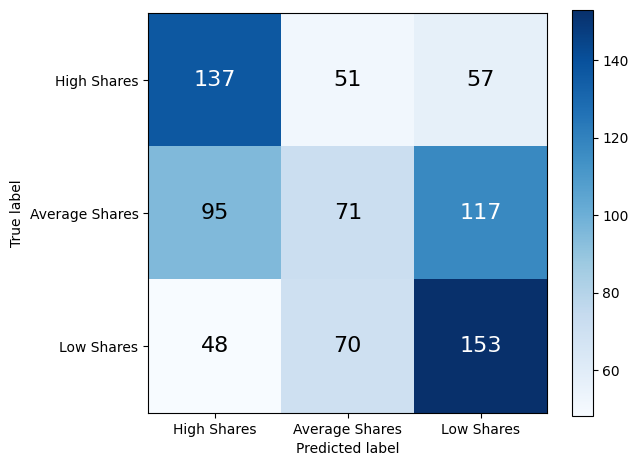

In [49]:
cb_GS = GridSearchCV(
    cb.CatBoostClassifier(objective='MultiClass', random_state=rand_state, verbose=False), 
    {
        'depth': [2, 5, 10],
        'n_estimators': [60, 100, 140],
        'learning_rate': [0.1, 0.01],
        'l2_leaf_reg': [1, 3, 5],
    }, 
    n_jobs=multiprocessing.cpu_count())

cb_GS = cb_GS.fit(X_train, y_train)

cb_best_model = cb_GS.best_estimator_
print(cb_best_model.get_params())

get_mean_cvs(cb_best_model, X_train, y_train)

cb_best_model.fit(X_train, y_train)
y_pred_cb_best = cb_best_model.predict(X_test)
evaluate_model(y_test, y_pred_cb_best)

In [62]:
pickle.dump(cb_best_model, open('./dataset/Model/cb_best_model.pkl', 'wb'))

## LightGBM

LGBMClassifier(objective='accuracy', random_state=2023)
Cross Validation Accuracy Score: 0.467 (0.030)
                precision    recall  f1-score   support

   High Shares       0.37      0.31      0.34       283
Average Shares       0.47      0.56      0.51       245
    Low Shares       0.51      0.51      0.51       271

      accuracy                           0.45       799
     macro avg       0.45      0.46      0.45       799
  weighted avg       0.45      0.45      0.45       799



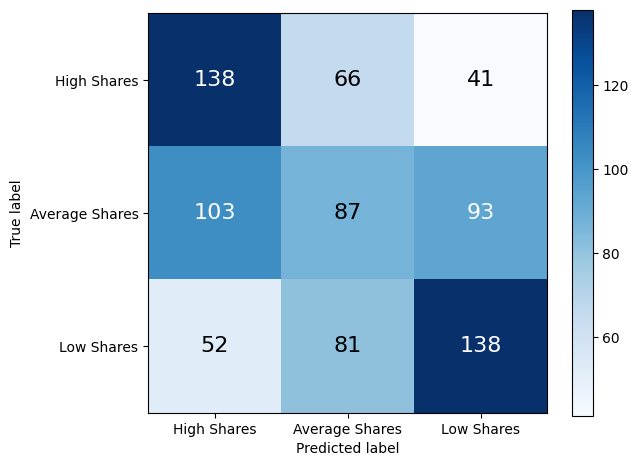

In [44]:
lgb_base_model = lgb.LGBMClassifier(
    objective='accuracy', 
    random_state=rand_state
)
print(lgb_base_model)

get_mean_cvs(lgb_base_model, X_train, y_train.to_numpy().ravel())

lgb_base_model.fit(X_train, y_train)
y_pred_lgb_base = lgb_base_model.predict(X_test)
evaluate_model(y_test, y_pred_lgb_base)

LGBMClassifier(max_depth=2, num_leaves=10, objective='accuracy',
               random_state=2023, subsample=0.5)
Cross Validation Accuracy Score: 0.483 (0.025)
                precision    recall  f1-score   support

   High Shares       0.39      0.28      0.32       283
Average Shares       0.48      0.55      0.51       245
    Low Shares       0.50      0.57      0.53       271

      accuracy                           0.46       799
     macro avg       0.45      0.47      0.46       799
  weighted avg       0.45      0.46      0.45       799



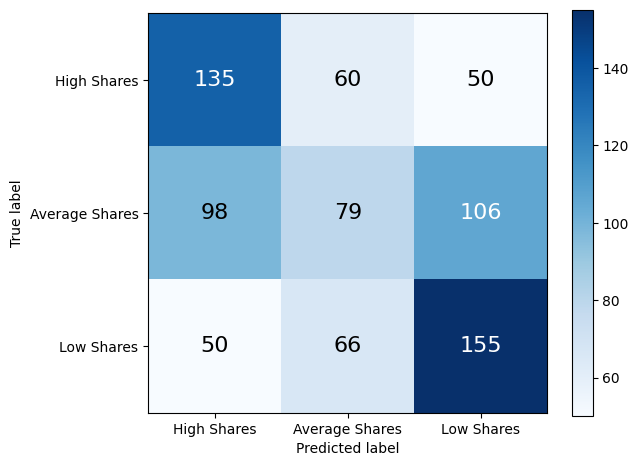

In [42]:
lgb_GS = GridSearchCV(
    lgb.LGBMClassifier(objective='accuracy', random_state=rand_state), 
    {
        'max_depth': [2, 5, 10],
        'n_estimators': [60, 100, 140],
        'learning_rate': [0.1, 0.01],
        'num_leaves': [10, 20, 30],
        'subsample': [0.5, 0.7, 0.9], 
    }, 
    n_jobs=multiprocessing.cpu_count())

lgb_GS = lgb_GS.fit(X_train, y_train.to_numpy().ravel())

lgb_best_model = lgb_GS.best_estimator_
print(lgb_best_model)

get_mean_cvs(lgb_best_model, X_train, y_train.to_numpy().ravel())

lgb_base_model.fit(X_train, y_train)
y_pred_lgb_best = lgb_best_model.predict(X_test)
evaluate_model(y_test, y_pred_lgb_best)

In [63]:
pickle.dump(lgb_best_model, open('./dataset/Model/lgb_best_model.pkl', 'wb'))

## Adaboost

AdaBoostClassifier(random_state=2023)
Cross Validation Accuracy Score: 0.471 (0.028)
                precision    recall  f1-score   support

   High Shares       0.37      0.26      0.31       283
Average Shares       0.45      0.56      0.50       245
    Low Shares       0.50      0.55      0.52       271

      accuracy                           0.45       799
     macro avg       0.44      0.46      0.44       799
  weighted avg       0.44      0.45      0.44       799



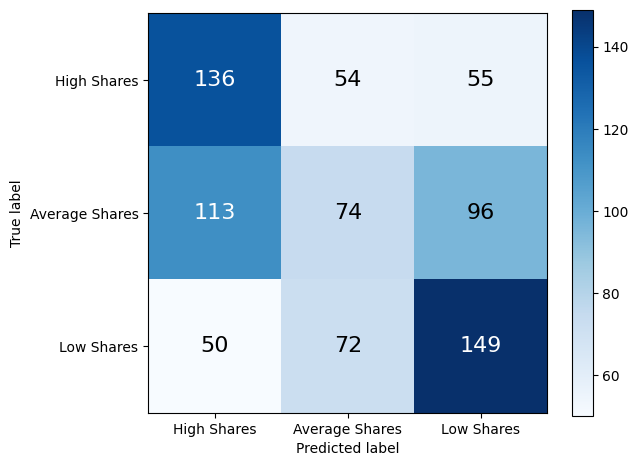

In [51]:
ada_base_model = AdaBoostClassifier(
    random_state=rand_state
)
print(ada_base_model)

get_mean_cvs(ada_base_model, X_train, y_train.to_numpy().ravel())

ada_base_model.fit(X_train, y_train)
y_pred_lgb_base = ada_base_model.predict(X_test)
evaluate_model(y_test, y_pred_lgb_base)

AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=2023)
Cross Validation Accuracy Score: 0.485 (0.029)
                precision    recall  f1-score   support

   High Shares       0.41      0.28      0.33       283
Average Shares       0.52      0.57      0.54       245
    Low Shares       0.46      0.58      0.52       271

      accuracy                           0.47       799
     macro avg       0.46      0.48      0.46       799
  weighted avg       0.46      0.47      0.46       799



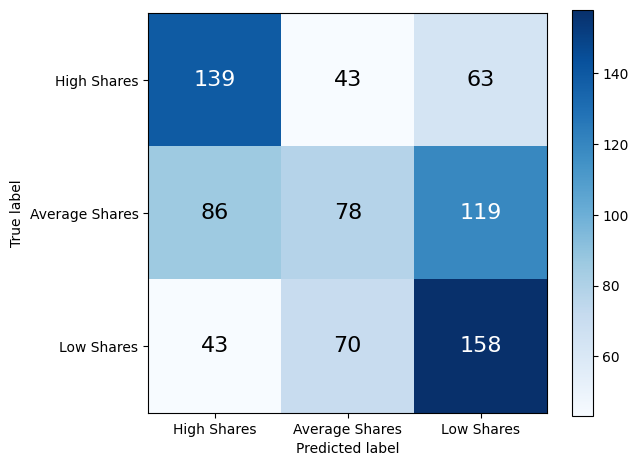

In [65]:
ada_GS = GridSearchCV(
    AdaBoostClassifier(random_state=rand_state), 
    {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    }, 
    n_jobs=multiprocessing.cpu_count())

ada_GS = ada_GS.fit(X_train, y_train.to_numpy().ravel())

ada_best_model = ada_GS.best_estimator_
print(ada_best_model)

get_mean_cvs(ada_best_model, X_train, y_train.to_numpy().ravel())

lgb_base_model.fit(X_train, y_train)
y_pred_ada_best = ada_best_model.predict(X_test)
evaluate_model(y_test, y_pred_ada_best)

In [66]:
pickle.dump(ada_best_model, open('./dataset/Model/ada_best_model.pkl', 'wb'))

In [ ]:
ab_base_model =  AdaBoostClassifier(n_estimators=100, random_state=rand_state)
get_mean_cvs(ab_base_model, X_train, y_train)

Cross Validation Accuracy Score: 0.465 (0.028)


array([0.4375    , 0.453125  , 0.45625   , 0.44514107, 0.45454545,
       0.45454545, 0.47335423, 0.44827586, 0.46081505, 0.49216301,
       0.478125  , 0.4625    , 0.453125  , 0.49529781, 0.54231975,
       0.44200627, 0.42946708, 0.43887147, 0.42946708, 0.47962382,
       0.4625    , 0.453125  , 0.45      , 0.49216301, 0.50783699,
       0.4200627 , 0.48902821, 0.44827586, 0.4984326 , 0.51410658])

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                precision    recall  f1-score   support

   High Shares       0.39      0.31      0.34       283
Average Shares       0.47      0.56      0.51       245
    Low Shares       0.49      0.51      0.50       271

      accuracy                           0.45       799
     macro avg       0.45      0.46      0.45       799
  weighted avg       0.45      0.45      0.45       799



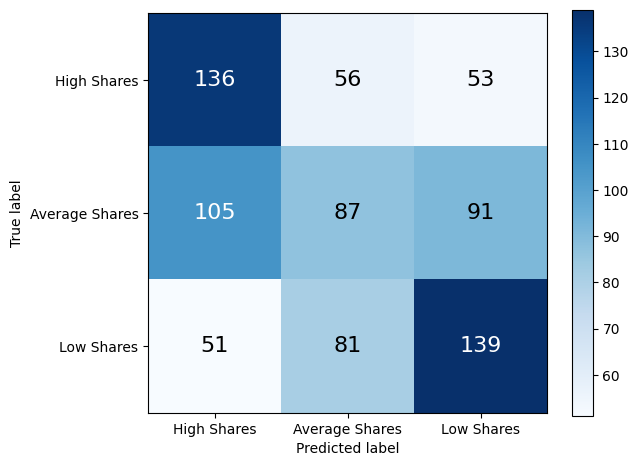

In [ ]:
ab_base_model.fit(X_train, y_train)
y_pred_ab_base = ab_base_model.predict(X_test)
evaluate_model(y_test, y_pred_ab_base)

In [ ]:
params = {"n_estimators": [25,50,100,200],
          "learning_rate": [0.01, 0.1, 1.0]
          }

ab_model =  AdaBoostClassifier()

ab_best_params = get_best_params(model=ab_model,
                                 grid=params,
                                 X=X_train,
                                 y=y_train,
                                 is_iterate_all=False)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best: -1.0541577301039349 using {'n_estimators': 50, 'learning_rate': 0.01}
-1.0740981043462114 (0.001215878723778299) with: {'n_estimators': 50, 'learning_rate': 0.1}
-1.087260565245316 (0.001277844542557686) with: {'n_estimators': 25, 'learning_rate': 1.0}
-1.056803517977993 (0.0034705064728782708) with: {'n_estimators': 100, 'learning_rate': 0.01}
-1.0553976568272914 (0.009253704438363554) with: {'n_estimators': 25, 'learning_rate': 0.01}
-1.0926319435296699 (0.0013598535052255936) with: {'n_estimators': 100, 'learning_rate': 1.0}
-1.0629088276738767 (0.0023147464201517293) with: {'n_estimators': 200, 'learning_rate': 0.01}
-1.06488918359689 (0.0020278361933582364) with: {'n_estimators': 25, 'learning_rate': 0.1}
-1.0541577301039349 (0.005523629009765593) with: {'n_estimators': 50, 'learning_rate': 0.01}
-1.0948652574299433 (0.0008726738173769893) with: {'n_estimators': 200, 'learning_rate': 1.0}
-1.081502563637835 (0.0009455889552752935) with: {'n_estimators': 100, 'learning_rate':

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

                precision    recall  f1-score   support

   High Shares       0.00      0.00      0.00       283
Average Shares       0.41      0.67      0.51       245
    Low Shares       0.44      0.65      0.52       271

      accuracy                           0.43       799
     macro avg       0.28      0.44      0.34       799
  weighted avg       0.28      0.43      0.33       799



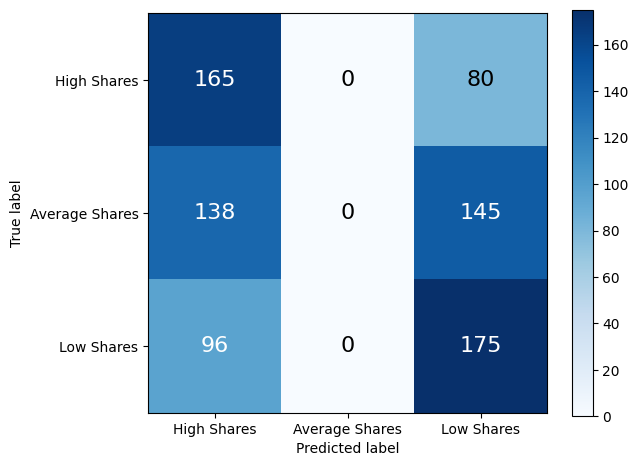

In [ ]:
# Parameters to be tuned (Runtime at 2h20mins)
max_features = ['auto', 'sqrt']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# Placing parameters into a dictionary
parameters= {
    'max_features': max_features,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
}
ab_best_model = AdaBoostClassifier(n_estimators = 50, learning_rate = 0.01).fit(X_train, y_train)
y_pred_ab_best = ab_best_model.predict(X_test)
evaluate_model(y_test, y_pred_ab_best)

In [ ]:
ab_best_model.feature_names_in_

array(['timedelta', 'n_tokens_title', 'n_tokens_preview',
       'preview_subjectivity', 'n_tokens_content', 'prop_non_stop',
       'prop_unique_non_stop', 'num_imgs', 'num_hrefs', 'n_tokens_cross',
       'subjectivity_cross', 'content_cross', 'subcategory1_Attractions',
       'subcategory1_Australia', 'subcategory1_Beauty & Wellness',
       'subcategory1_Food Guides', 'subcategory1_Malaysia',
       'subcategory1_Sales & Promotions',
       'author_category_100 to 200 posts',
       'author_category_More than 200 posts', '0', '1', '2', '3', '4',
       '5', '6', '7', '8', '9', '0.1', '1.1', '2.1', '3.1', '4.1', '5.1',
       '6.1', '7.1', '8.1', '9.1', '0.2', '1.2', '2.2', '3.2', '4.2',
       '5.2', '6.2', '7.2', '8.2', '9.2'], dtype=object)

In [ ]:

pd.DataFrame({'feature': ab_best_model.feature_names_in_, 'score': ab_best_model.feature_importances_}).set_index('feature').squeeze().sort_values(ascending = False)[:10]

feature
timedelta    0.60
num_imgs     0.34
0.1          0.06
8.1          0.00
8            0.00
9            0.00
1.1          0.00
2.1          0.00
3.1          0.00
4.1          0.00
Name: score, dtype: float64

In [ ]:
evaluate_model(y_test, y_pred_ab_base)

# 4. Convolutional Neural Network

In [ ]:
X_train = pd.read_csv('./drive/My Drive/IS4242/datasets/X_train.csv')
y_train = pd.read_csv('./drive/My Drive/IS4242/datasets/y_train.csv')

X_test = pd.read_csv('./drive/My Drive/IS4242/datasets/X_test.csv')
y_test = pd.read_csv('./drive/My Drive/IS4242/datasets/y_test.csv')

In [ ]:
mapping = {"Low Shares": 0, "Average Shares": 1, "High Shares": 2}

y_train['num_shares_bin'] = y_train['num_shares_bin'].map(mapping)
y_test['num_shares_bin'] = y_test['num_shares_bin'].map(mapping)

In [ ]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
import tensorflow
from tensorflow.keras.utils import to_categorical
# Reshape X_train and X_test
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Reshape y_train and y_test
# One-hot encode target variables
y_train_encode = to_categorical(y_train)
y_test_encode = to_categorical(y_test)


In [ ]:
print(X_train.shape)
print(y_train_encode.shape)
print(X_test.shape)
print(y_test_encode.shape)

(3193, 50, 1)
(3193, 3)
(799, 50, 1)
(799, 3)


In [ ]:
# Import necessary libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import tensorflow as tf

tf.keras.utils.set_random_seed(1)

# Build the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2, padding="same"))
model.add(Dropout(0.2))
model.add(Conv1D(64, kernel_size=2,padding="same", activation="linear"))
model.add(MaxPooling1D(pool_size=2, padding="same"))
model.add(Dropout(0.2))
model.add(Conv1D(32, kernel_size=2,padding="same", activation="linear"))
model.add(MaxPooling1D(pool_size=2, padding="same"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encode, epochs=25, batch_size=32, validation_data=(X_test, y_test_encode))


Epoch 1/25
100/100 [==============================] - 3s 18ms/step - loss: 6062.0186 - accuracy: 0.3276 - val_loss: 2420.8489 - val_accuracy: 0.3542
Epoch 2/25
100/100 [==============================] - 1s 14ms/step - loss: 2133.2334 - accuracy: 0.3288 - val_loss: 196.6582 - val_accuracy: 0.3392
Epoch 3/25
100/100 [==============================] - 1s 14ms/step - loss: 1103.0475 - accuracy: 0.3342 - val_loss: 246.6437 - val_accuracy: 0.3079
Epoch 4/25
100/100 [==============================] - 1s 15ms/step - loss: 660.2885 - accuracy: 0.3451 - val_loss: 119.7515 - val_accuracy: 0.3066
Epoch 5/25
100/100 [==============================] - 2s 16ms/step - loss: 405.5176 - accuracy: 0.3276 - val_loss: 65.4854 - val_accuracy: 0.3579
Epoch 6/25
100/100 [==============================] - 2s 22ms/step - loss: 230.8657 - accuracy: 0.3335 - val_loss: 27.8691 - val_accuracy: 0.3517
Epoch 7/25
100/100 [==============================] - 3s 31ms/step - loss: 131.4828 - accuracy: 0.3398 - val_loss: 2

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
# Make predictions on test data
y_pred = model.predict(X_test)

# Convert predictions from one-hot encoding to class labels
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test.flatten(), y_pred))

25/25 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.41      0.73      0.52       271
           1       0.35      0.37      0.36       283
           2       0.61      0.04      0.08       245

    accuracy                           0.39       799
   macro avg       0.46      0.38      0.32       799
weighted avg       0.45      0.39      0.33       799



# Model Evaluation